In [1]:
!cp drive/My\ Drive/natural-language-processing/q4_train.zip .

In [2]:
!unzip q4_train.zip

Archive:  q4_train.zip
   creating: train/
  inflating: train/train.csv         
  inflating: train/test.csv          


#### Loading dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_train = pd.read_csv('train/train.csv')
df_test  = pd.read_csv('train/test.csv')

• Five binary variables 
• Ten nominal variables 
• Six ordinal variables 
• Two cyclic variables 
• And a target variable

In [5]:
df_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0.0,1.0,0.0,F,N,Blue,Circle,Hamster,Costa Rica,Theremin,b165c9589,6fc4f10fb,22a1b223f,1a59581be,e184f0df9,2.0,Master,Freezing,e,N,oh,3.0,5.0,0
1,1.0,1.0,0.0,F,Y,Blue,Trapezoid,Dog,India,Theremin,0289ab250,c3b174e52,5e17197af,ca9ad1d4b,a91d577f9,1.0,Contributor,Freezing,f,N,Kq,3.0,8.0,0
2,0.0,0.0,0.0,F,N,Red,Circle,Hamster,India,Bassoon,337a3bd19,c18193dac,56d35c774,32ff72b97,7813e67c3,2.0,NaN,Cold,i,D,Fl,3.0,3.0,0
3,0.0,0.0,0.0,T,N,Green,Polygon,Hamster,India,Theremin,024efa364,9043b0882,e60e65034,46a005ddf,55fe9a4b8,1.0,Grandmaster,Cold,n,Z,In,7.0,7.0,0
4,0.0,0.0,0.0,F,N,Blue,Polygon,Axolotl,Costa Rica,Bassoon,7b0da9c0f,7a22f53ea,f74f0b894,NaN,512255ae7,1.0,Expert,Hot,i,X,Sk,5.0,2.0,1


#### Nan values
- All features have nan values

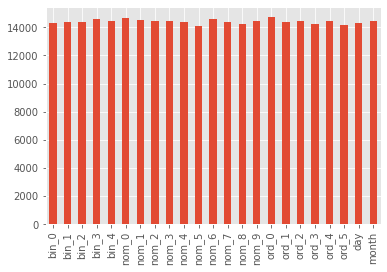

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.DataFrame(df_train[df_train.columns[:-1]].isna().sum()).plot(kind='bar', legend=False);

#### Dataset is skewed

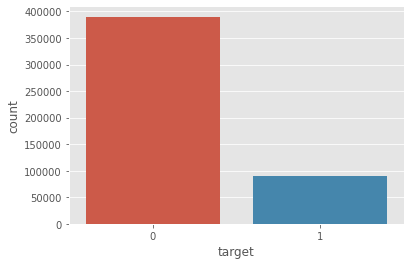

In [25]:
import seaborn as sns

sns.countplot(x=df_train['target'], data=df_train);

#### Feature encoding and Model preparation

##### Class weights

In [39]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['target']),
                                                 df_train['target'])
{0: class_weights[0], 1: class_weights[1]}

{0: 0.6151606338205063, 1: 2.6708807229183824}

##### Model 

In [46]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from warnings import filterwarnings
filterwarnings('ignore')

def run(df_train, df_test):

  # filling nan values fill NONE -> to have a new value in all features
  features = [ft for ft in df_train.columns if ft not in ['target']]
  for col in features:
    df_train.loc[:,col] = df_train[col].astype(str).fillna('NONE')
    df_test.loc[:,col]  = df_test[col].astype(str).fillna('NONE')

  # one-hot encoding all the features
  ohe = preprocessing.OneHotEncoder()
  full_data = pd.concat([df_train, df_test], axis=0)
  ohe.fit(full_data[features])

  x_train = ohe.transform(df_train[features])
  x_test  = ohe.transform(df_test[features])

  # Start with a simple model -> Logistic Regression
  model = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})
  model.fit(x_train, df_train['target'].values)

  # Prediction
  train_preds = model.predict_proba(x_train)[:,1]
  test_preds = model.predict_proba(x_test)

  # ROC AUC score
  auc = metrics.roc_auc_score(df_train['target'].values, train_preds)
  print(f'AUC score on training set: {auc:.2f}')

  return test_preds

test_pred = run(df_train, df_test)

AUC score on training set: 0.80


#### Submission

In [45]:
d = pd.DataFrame(test_pred[:,1], columns=['Target'])
d.to_csv('submission.csv', index=False)

# will score 128 out of 160 